## Initial test runs - basic simulations, *dense* fields where PSFs are known perfectly.

In [11]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 16
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

#import time
#time.sleep(600)

16


[0.00083755297927673943, 0.00085553432826155956]
(7.5967275689784346, 22.904165312892815, -70.494936069740646, 3654.989393726783)
(15.050555909781027, 30.586338876597218, -81.532301152145635, 2667.9467603722696)
(307.59672756897845, 22.904165312892811, 229.50506393025935, 3954.989393726783)
(315.050555909781, 30.586338876597214, 218.46769884785436, 2967.9467603722696)


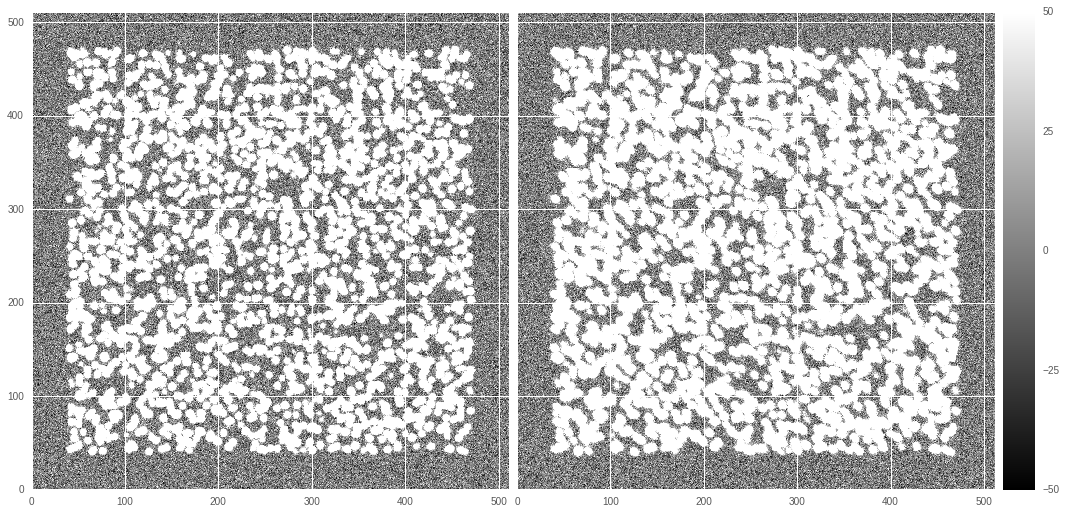

In [32]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

n_sources = 2500

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.], variablesNearCenter=False,
                         theta1=0., theta2=-45., im2background=0., n_sources=n_sources, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

print testObj.astrometricOffsets
print dit.computeClippedImageStats(testObj.im1.im)
print dit.computeClippedImageStats(testObj.im2.im)
print dit.computeClippedImageStats(testObj.im1.var)
print dit.computeClippedImageStats(testObj.im2.var)

fig = plt.figure(1, (18, 18))
dit.plotImageGrid((testObj.im1.im, testObj.im2.im), clim=(-50,50))

Interesting - above about 1500 sources, this fails on S_ZOGY but only with NaiveDipoleCentroid. So I turned that off in the detection code, and all seems well again.

Update: SZOGY fails because the threshold for computeAstrometricOffsets() was too high (2.5). Set it to 0.5 and all is better.

In [33]:
src = testObj.runTest(returnSources=True)

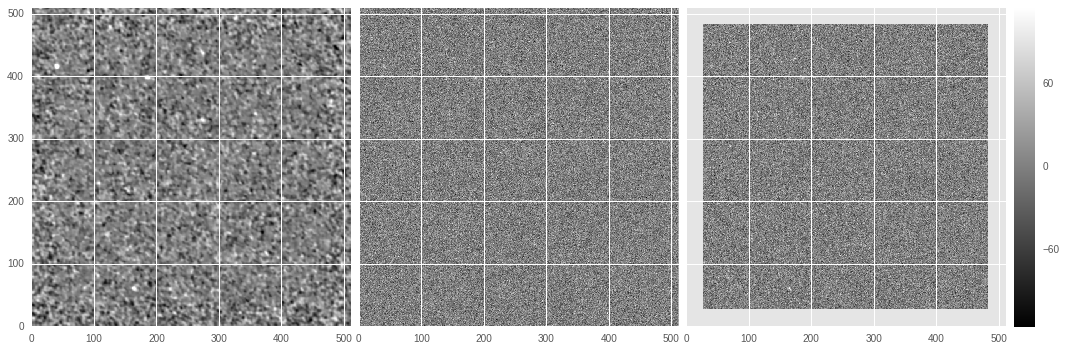

In [34]:
fig = plt.figure(1, (18, 18))
dit.plotImageGrid((testObj.S_corr_ZOGY.im,
                   testObj.D_ZOGY.im,
                   testObj.res.decorrelatedDiffim.getMaskedImage().getImage().getArray()))

In [35]:
changedCentroid = np.array(testObj.centroids[testObj.changedCentroidInd, :])
print changedCentroid

#print src['AL'][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PsfFlux_fluxSigma', 'base_PsfFlux_flag']]
for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']:
    print key
    if key is not 'SZOGY':
        fsKey = 'base_PsfFlux_fluxSigma'
    else: # For SZOGY, the correct flux measurement is PeakLikelihoodFlux
        fsKey = 'base_PeakLikelihoodFlux_fluxSigma'
    print src[key][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', fsKey, 'base_PsfFlux_flag']]

[[  165.15463891    60.92011564     0.          1500.        ]
 [   40.8754355    415.99091391     0.          1500.        ]
 [  186.45621549   397.17030423     0.          1500.        ]]
ALstack
   base_NaiveCentroid_x  base_NaiveCentroid_y  base_PsfFlux_fluxSigma base_PsfFlux_flag
0            164.988360             60.968832              263.549781             False
1            186.414614            397.141710              211.924952             False
ZOGY
   base_NaiveCentroid_x  base_NaiveCentroid_y  base_PsfFlux_fluxSigma base_PsfFlux_flag
0            164.357963             61.052222              256.419473             False
1            186.389499            397.149269              212.010711             False
2             39.796135            416.075058              166.609370             False
SZOGY
   base_NaiveCentroid_x  base_NaiveCentroid_y  base_PeakLikelihoodFlux_fluxSigma base_PsfFlux_flag
0            164.008057             61.030882                          41.96

In [36]:
reload(dit)

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                         varFlux2=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.], variablesNearCenter=False,
                         theta1=0., theta2=-45., im2background=0., n_sources=n_sources, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

det = testObj.runTest()
print det

{'ZOGY': {'FP': 0, 'FN': 0, 'TP': 8}, 'ALstack': {'FP': 0, 'FN': 1, 'TP': 7}, 'SZOGY': {'FP': 3, 'FN': 1, 'TP': 7}, 'ALstack_noDecorr': {'FP': 0, 'FN': 0, 'TP': 8}}


Try some real tests!

In [37]:
# Default 10 sources with same flux
def runTest(flux, seed=66, sky=300., n_sources=50, n_varSources=1):
    #methods = ['ALstack', 'ZOGY', 'ZOGY_S', 'ALstack_noDecorr']
    testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                             varFlux2=np.repeat(flux, n_varSources), variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(500,30000), seed=seed, psfSize=13)
    det = {'flux': flux}
    try:
        det = testObj.runTest() #subtractMethods=methods) #, 'AL'])
    except:
        pass
    return det

methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']

## Look at detection rates for 5.0-sigma sources.

In [38]:
reload(dit)
inputs = [(f, seed) for f in [1500] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults1 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=n_sources, 
                                                                      n_varSources=10) for i in inputs)

100


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   18.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:  1.9min finished


FN: 
ALstack             0.94
ALstack_noDecorr    0.65
SZOGY               2.03
ZOGY                0.54
dtype: float64
FP: 
ALstack             1.03
ALstack_noDecorr    1.43
SZOGY               2.30
ZOGY                0.40
dtype: float64
TP: 
ALstack             9.06
ALstack_noDecorr    9.35
SZOGY               7.97
ZOGY                9.46
dtype: float64


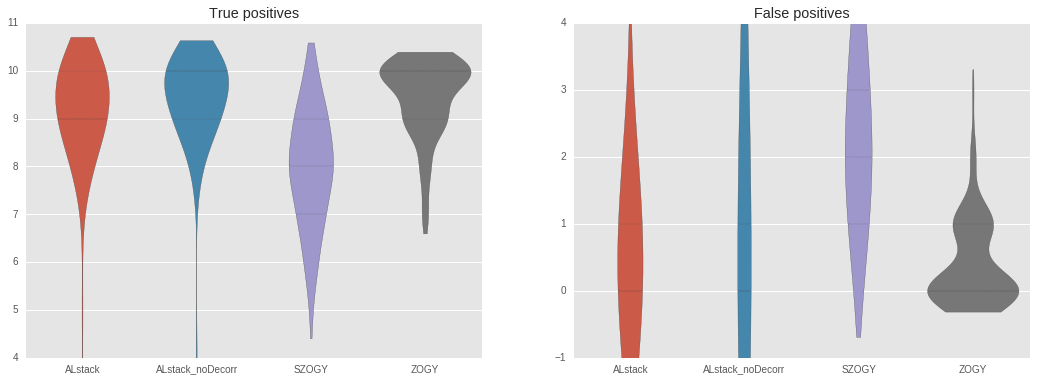

In [39]:
def plotResults(tr):
    FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
    FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})
    TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
    print 'FN:', '\n', FN.mean()
    print 'FP:', '\n', FP.mean()
    print 'TP:', '\n', TP.mean()

    matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
    fig, axes = plt.subplots(nrows=1, ncols=2)

    sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[0])
    axes[0].set_title('True positives')
    axes[0].set_ylim((4, 11))
    sns.violinplot(data=FP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[1])
    axes[1].set_title('False positives')
    axes[1].set_ylim((-1, 4))
    
plotResults(testResults1)

## Look at detection rates for 3.33-sigma sources.

In [40]:
inputs = [(f, seed) for f in [1000] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults2 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=100, n_varSources=10) \
                                                     for i in inputs)

100


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   13.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:  1.4min finished


FN: 
ALstack             2.31
ALstack_noDecorr    2.03
SZOGY               2.93
ZOGY                2.06
dtype: float64
FP: 
ALstack             1.07
ALstack_noDecorr    1.04
SZOGY               1.74
ZOGY                1.20
dtype: float64
TP: 
ALstack             7.69
ALstack_noDecorr    7.97
SZOGY               7.07
ZOGY                7.94
dtype: float64


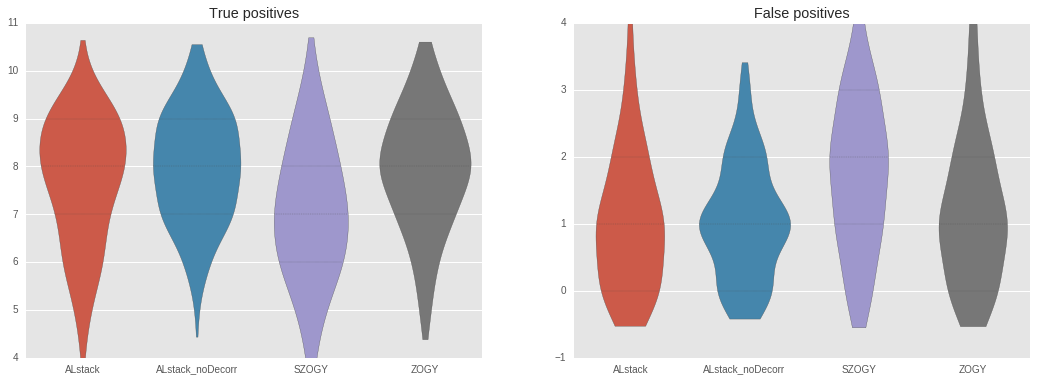

In [41]:
plotResults(testResults2)

## For fun, try some 10-sigma sources.

In [42]:
inputs = [(f, seed) for f in [3000] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults3 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=100, n_varSources=10) \
                                                     for i in inputs)

100


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   14.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:  1.5min finished


FN: 
ALstack             0.43
ALstack_noDecorr    0.27
SZOGY               0.28
ZOGY                0.24
dtype: float64
FP: 
ALstack             0.03
ALstack_noDecorr    0.05
SZOGY               0.10
ZOGY                0.06
dtype: float64
TP: 
ALstack             9.57
ALstack_noDecorr    9.73
SZOGY               9.72
ZOGY                9.76
dtype: float64


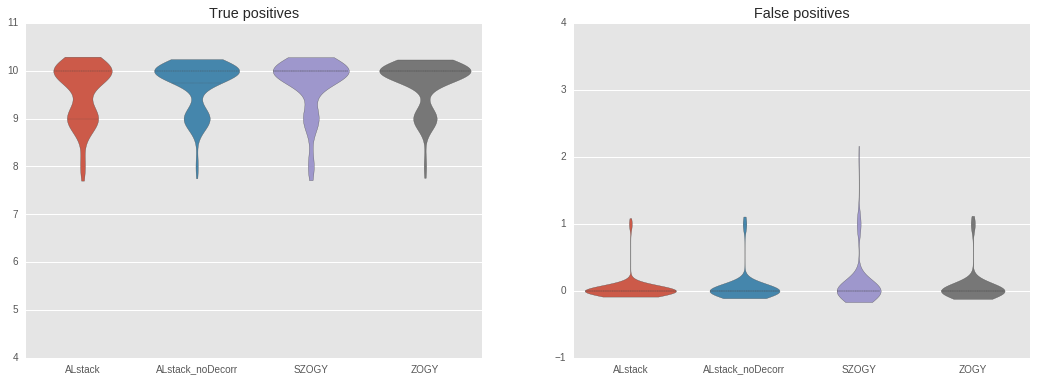

In [43]:
plotResults(testResults3)